<a href="https://colab.research.google.com/github/juwetta/DLI_Group-B/blob/main/DLI_Malicious_URL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Import imporant libraries

In [2]:
import os
from sklearn.datasets import load_svmlight_file
import glob
import scipy.sparse
import numpy as np

[code below is used for lower the size of dataset, since the full dataset can used up all the RAM just to storing them]

In [3]:
# import shutil

# # Define the source folder path
# source_folder = '/content/drive/My Drive/DLI Group B/url_svmlight'

# # Define the destination folder path
# destination_folder = '/content/drive/My Drive/DLI Group B/url_dataset'

# # Create the destination folder if it doesn't exist
# os.makedirs(destination_folder, exist_ok=True)

# # List of files to copy (Day0.svm to Day60.svm and FeatureTypes)
# files_to_copy = [f'Day{i}.svm' for i in range(61)] + ['FeatureTypes']

# print(f"Copying files to: {destination_folder}")

# # Copy the specified files
# for file_name in files_to_copy:
#     source_file_path = os.path.join(source_folder, file_name)
#     destination_file_path = os.path.join(destination_folder, file_name)
#     try:
#         shutil.copy2(source_file_path, destination_file_path)
#         print(f"Copied: {file_name}")
#     except FileNotFoundError:
#         print(f"Warning: File not found - {file_name}. Skipping.")
#     except Exception as e:
#         print(f"Error copying file {file_name}: {e}")

# print("File copying process completed.")

Accessing to folder

In [4]:
folder_path = '/content/drive/My Drive/DLI Group B/url_dataset'

svm_files = glob.glob(os.path.join(folder_path, "*.svm"))
print(f"Found {len(svm_files)} SVM files in: {folder_path}")

Found 21 SVM files in: /content/drive/My Drive/DLI Group B/url_dataset


In the context of the output, "shape" refers to the dimensions of the data structure (like a NumPy array or a SciPy sparse matrix).

For a 2D structure like combined_X, the shape (2396130, 3231961) means it has 2,396,130 rows and 3,231,961 columns. In this dataset, the rows represent the samples (e.g., URLs), and the columns represent the features.
For a 1D structure like combined_y, the shape (2396130,) means it has 2,396,130 elements. This corresponds to the labels for each of the samples in combined_X.
So, the shape tells you how many samples you have and how many features or labels are associated with each sample.

Read SVM file and store dataset


the different SVM files have varying numbers of features, causing an error when trying to combine them. I'll add a step to determine the total number of features across all files and then load each file with that consistent number of features.

In [5]:
# max_features = 0

# for file_path in svm_files:
#   try:
#     X, _ = load_svmlight_file(file_path)
#     if X.shape[1] > max_features:
#       max_features = X.shape[1]

#   except Exception as e:
#     print(f"Error loading file {os.path.basename(file_path)}: {e}")


# print(f"Maximum number of features found: {max_features}") #74.777s used
max_features = 3231961
print(f"Maximum number of features found: {max_features}")

Maximum number of features found: 3231961


In [6]:

all_X = []
all_y = []
max_features = 3231961
try:
    print("\nLoading and combining data...")
    counter = 0
    # Load and combine data in a single pass, specifying the number of features
    for file_path in svm_files:
        try:
            if counter == 3: break
            X, y = load_svmlight_file(file_path, n_features=max_features)
            all_X.append(X)
            all_y.append(y)
            print(f"{os.path.basename(file_path)}", end="| ")
            counter += 1
        except Exception as e:
            print(f"Error loading file {os.path.basename(file_path)}: {e}")

    if all_X and all_y:
        # Vertically stack the sparse feature matrices
        combined_X = scipy.sparse.vstack(all_X)
        # Concatenate the label arrays
        combined_y = np.concatenate(all_y)

        print("\nSuccessfully combined data from all files.")
        print(f"Shape of combined data (X): {combined_X.shape}")
        print(f"Shape of combined labels (y): {combined_y.shape}")
    else:
        print("\nNo data was loaded from the SVM files.")


except FileNotFoundError:
    print(f"Folder not found at: {folder_path}")
except Exception as e:
    print(f"An error occurred: {e}") #75.54s used


Loading and combining data...
Day0.svm| Day1.svm| Day2.svm| 
Successfully combined data from all files.
Shape of combined data (X): (56000, 3231961)
Shape of combined labels (y): (56000,)


Identify the indexes of real-valued features

In [7]:
import os

feature_types_path = '/content/drive/My Drive/DLI Group B/url_dataset/FeatureTypes'
real_valued_feature_indices = set()

try:
    with open(feature_types_path, 'r') as f:
        for line in f:
            # Assuming each line in FeatureTypes is a feature index
            try:
                index = int(line.strip())
                real_valued_feature_indices.add(index)
            except ValueError:
                # Handle potential non-integer lines in the file
                print(f"Skipping non-integer line in FeatureTypes: {line.strip()}")

    print(f"Identified {len(real_valued_feature_indices)} real-valued feature indices.")
    # print("First 10 real-valued feature indices:", list(real_valued_feature_indices)[:10]) # Optional: print a few indices

except FileNotFoundError:
    print(f"FeatureTypes file not found at: {feature_types_path}")
except Exception as e:
    print(f"An error occurred while reading FeatureTypes: {e}")

# Now you have the set of real-valued feature indices and can use it
# For example, you could filter your data or analyze these specific features.

Identified 64 real-valued feature indices.


Briefly explore the dataset

In [8]:
# Select the first few rows to inspect
num_rows_to_inspect = 5
sample_rows = combined_X[:num_rows_to_inspect]

print(f"Values of real-valued features in the first {num_rows_to_inspect} rows:")

# Iterate through the selected rows
for i in range(sample_rows.shape[0]):
    print(f"\nRow {i+1}:")
    # Iterate through the real-valued feature indices
    for feature_index in sorted(list(real_valued_feature_indices)): # Sorting for consistent output
        # Check if the feature exists in the current row (i.e., it's non-zero)

        if feature_index in sample_rows[i].indices:
            # Get the index within the non-zero elements
            data_index = np.where(sample_rows[i].indices == feature_index)[0][0]
            # Get the value of the feature
            feature_value = sample_rows[i].data[data_index]
            print(f"  Feature {feature_index}: {feature_value}")
        # If the feature index is not in sample_rows[i].indices, its value is 0 in the sparse matrix,
        # so we don't need to explicitly print 0 unless we want to see all real-valued features
        # even if their value is 0 for that sample. Let's only print non-zero real-valued features.

Values of real-valued features in the first 5 rows:

Row 1:
  Feature 4: 0.124138
  Feature 5: 0.117647
  Feature 16: 0.749633
  Feature 17: 0.843029
  Feature 18: 0.197344
  Feature 21: 0.142857
  Feature 22: 0.142857
  Feature 55: 1.0
  Feature 63: 1.0
  Feature 69: 1.0
  Feature 71: 1.0
  Feature 73: 1.0
  Feature 75: 1.0
  Feature 81: 1.0
  Feature 83: 1.0
  Feature 85: 1.0
  Feature 87: 1.0
  Feature 89: 1.0
  Feature 91: 1.0
  Feature 93: 1.0
  Feature 95: 1.0
  Feature 101: 1.0
  Feature 103: 1.0
  Feature 105: 1.0
  Feature 107: 1.0
  Feature 109: 1.0
  Feature 111: 1.0

Row 2:
  Feature 4: 0.103448
  Feature 5: 0.176471
  Feature 16: 0.72266
  Feature 17: 0.836498
  Feature 18: 0.6189
  Feature 21: 0.0119048
  Feature 23: 1.0
  Feature 55: 1.0
  Feature 61: 1.0
  Feature 63: 1.0
  Feature 65: 1.0
  Feature 67: 1.0
  Feature 69: 1.0
  Feature 71: 1.0
  Feature 73: 1.0
  Feature 75: 1.0
  Feature 81: 1.0
  Feature 83: 1.0
  Feature 85: 1.0
  Feature 87: 1.0
  Feature 89: 1.0
  F

# Task
Balance the classes in the `combined_y` variable of the dataset.

## Check class distribution

### Subtask:
Analyze the current distribution of the target variable (`combined_y`) to see how imbalanced the classes are.


**Reasoning**:
Calculate and print the counts of each unique class in the `combined_y` array to understand the class distribution.



In [9]:
unique_classes, class_counts = np.unique(combined_y, return_counts=True)

print("Class distribution in combined_y:")
for class_val, count in zip(unique_classes, class_counts):
    print(f"Class {int(class_val)}: {count}")

Class distribution in combined_y:
Class -1: 35563
Class 1: 20437


## Choose a balancing technique

### Subtask:
Decide on an appropriate method for balancing the classes, such as oversampling (e.g., SMOTE), undersampling, or a combination.


## Apply the balancing technique

### Subtask:
Apply the balancing technique


**Reasoning**:
To balance the dataset, I will first import the necessary library, 'imlearn.under_sampling' 's 'NearMiss' to undersampling class of the majority.



In [10]:
# Step 1 (continued, FAST) - Balance classes without dense conversion
import numpy as np
import joblib
import pandas as pd
from collections import Counter

# Check class distribution
class_counts = Counter(combined_y)
print("Before balancing:", class_counts)

# Find majority and minority
classes = np.unique(combined_y)
maj_class = classes[np.argmax([class_counts[c] for c in classes])]
min_class = classes[np.argmin([class_counts[c] for c in classes])]

# Indices of each class
maj_idx = np.where(combined_y == maj_class)[0]
min_idx = np.where(combined_y == min_class)[0]

# Oversample minority by random choice with replacement
n_to_add = len(maj_idx) - len(min_idx)
extra_idx = np.random.choice(min_idx, size=n_to_add, replace=True)

# New balanced indices
balanced_idx = np.concatenate([maj_idx, min_idx, extra_idx])
np.random.shuffle(balanced_idx)

# Slice combined_X and combined_y without converting to dense
X_balanced = combined_X[balanced_idx]
y_balanced = combined_y[balanced_idx]

print("After balancing:", Counter(y_balanced))

# Save balanced dataset
joblib.dump((X_balanced, y_balanced), '/content/drive/MyDrive/cleaned_balanced_dataset_fast.joblib')

# Save CSV (optional — WARNING: huge if dense)


Before balancing: Counter({np.float64(-1.0): 35563, np.float64(1.0): 20437})
After balancing: Counter({np.float64(-1.0): 35563, np.float64(1.0): 35563})


['/content/drive/MyDrive/cleaned_balanced_dataset_fast.joblib']

In [11]:
from imblearn.under_sampling import NearMiss

# Instantiate NearMiss
# NearMiss has different versions (1, 2, 3). You can experiment with them.
# NearMiss-1 selects samples from the majority class whose average distance to the k nearest samples of the minority class is smallest.
# NearMiss-2 selects samples from the majority class whose average distance to the k farthest samples of the minority class is smallest.
# NearMiss-3 selects samples from the majority class whose distance to the k nearest samples of the minority class is largest.
# Let's start with NearMiss-1.
nm = NearMiss(version=1, sampling_strategy='auto', n_neighbors=1) # Adjust n_neighbors if needed

print("Applying NearMiss undersampling...")
temp_combined_X, temp_combined_y = combined_X, combined_y
# Apply NearMiss to the data
# NearMiss works directly on the original data
X_resampled, y_resampled = nm.fit_resample(temp_combined_X, temp_combined_y)

# Print the shapes of the resampled data to verify
print(f"Shape of X after NearMiss: {X_resampled.shape}")
print(f"Shape of y after NearMiss: {y_resampled.shape}")

# Verify the new class distribution
unique_classes_resampled, class_counts_resampled = np.unique(y_resampled, return_counts=True)
print("\nClass distribution after resampling:")
for class_val, count in zip(unique_classes_resampled, class_counts_resampled):
    print(f"Class {int(class_val)}: {count}")

Applying NearMiss undersampling...
Shape of X after NearMiss: (40874, 3231961)
Shape of y after NearMiss: (40874,)

Class distribution after resampling:
Class -1: 20437
Class 1: 20437


## Train a classification model

Train a classification model on the balanced dataset.

In [12]:
from sklearn.model_selection import train_test_split

# Split the resampled data into training and testing sets
# Using a common split ratio like 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print("Dataset split into training and testing sets.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Dataset split into training and testing sets.
Shape of X_train: (32699, 3231961)
Shape of X_test: (8175, 3231961)
Shape of y_train: (32699,)
Shape of y_test: (8175,)


## Train a Support Vector Machine Model

Train a Linear Support Vector Classification model on the balanced dataset.

In [13]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Training Linear SVC model...")

# Initialize and train the LinearSVC model
# Adjust max_iter if convergence warnings occur
svm_model = LinearSVC(max_iter=2000, random_state=42)
svm_model.fit(X_train, y_train)

print("Model training complete.")

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("\nLinear SVC Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

Training Linear SVC model...
Model training complete.

Linear SVC Model Evaluation:
Accuracy: 0.9872782874617737

Confusion Matrix:
 [[4002   86]
 [  18 4069]]

Classification Report:
               precision    recall  f1-score   support

        -1.0       1.00      0.98      0.99      4088
         1.0       0.98      1.00      0.99      4087

    accuracy                           0.99      8175
   macro avg       0.99      0.99      0.99      8175
weighted avg       0.99      0.99      0.99      8175



In [14]:
import pickle
import os

# Define the path to save the model file in Google Drive
model_save_path = '/content/drive/My Drive/DLI Group B/url_dataset/svm_model.pkl'

try:
    # Ensure the directory exists
    save_dir = os.path.dirname(model_save_path)
    os.makedirs(save_dir, exist_ok=True)

    # Save the model to the specified path
    with open(model_save_path, 'wb') as f:
        pickle.dump(svm_model, f)

    print(f"SVM model successfully saved to: {model_save_path}")

except Exception as e:
    print(f"Error saving the model: {e}")

SVM model successfully saved to: /content/drive/My Drive/DLI Group B/url_dataset/svm_model.pkl


## Linear SVC Model Evaluation

Analyze the performance of the trained Linear SVC model.

# Task
Produce metrics, plots, and statistical tests to evaluate the performance of two classification models.

## Generate additional classification metrics

### Subtask:
Calculate and display additional relevant classification metrics beyond accuracy, confusion matrix, and classification report for both models, such as AUC-ROC or Precision-Recall curves, which are particularly useful for imbalanced datasets.


**Reasoning**:
Calculate and display additional relevant classification metrics for both models.



In [15]:
import pickle
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Define the path to load the SVM model file from Google Drive
model_load_path = '/content/drive/My Drive/DLI Group B/url_dataset/svm_model.pkl'

try:
    # Load the SVM model from the specified path
    with open(model_load_path, 'rb') as f:
        loaded_svm_model = pickle.load(f)

    print(f"SVM model successfully loaded from: {model_load_path}")

    # Use the loaded model to calculate and display additional metrics

    # Assuming X_test and y_test are available from a previous split
    # If you haven't split the data yet, you'll need to do that before this step.
    # For now, I'll assume X_test and y_test are available.
    # If not, you might need to split the resampled data into training and testing sets.
    # Replace X_test and y_test with your actual test variables if they are named differently.

    # For Linear SVC model
    # Calculate decision function scores
    y_scores_svm = loaded_svm_model.decision_function(X_test)

    # Calculate ROC curve and AUC
    # Note: roc_curve and precision_recall_curve expect scores for the positive class.
    # For LinearSVC, decision_function returns scores where positive values typically correspond to the positive class.
    # Ensure the pos_label matches the positive class in y_test (which is 1).
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_scores_svm, pos_label=1)
    roc_auc_svm = auc(fpr_svm, tpr_svm)

    # Calculate Precision-Recall curve and average precision score
    precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_scores_svm, pos_label=1)
    avg_precision_svm = average_precision_score(y_test, y_scores_svm, pos_label=1)

    print("Linear SVC Model Evaluation (Additional Metrics):")
    print(f"AUC-ROC: {roc_auc_svm:.4f}")
    print(f"Average Precision Score: {avg_precision_svm:.4f}")

except FileNotFoundError:
    print(f"Error: Model file not found at: {model_load_path}")
except Exception as e:
    print(f"An error occurred while loading or evaluating the model: {e}")

SVM model successfully loaded from: /content/drive/My Drive/DLI Group B/url_dataset/svm_model.pkl
Linear SVC Model Evaluation (Additional Metrics):
AUC-ROC: 0.9989
Average Precision Score: 0.9988


## Visualize model performance

### Subtask:
Generate visualizations to help understand the model's performance, such as ROC curves or Precision-Recall curves.

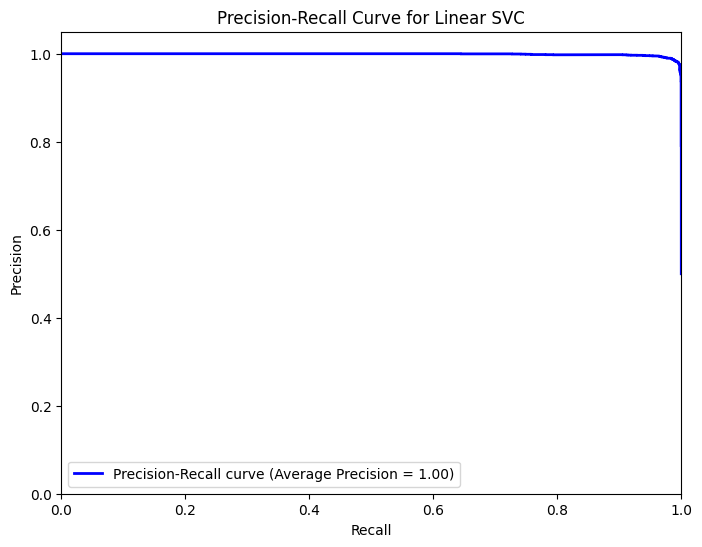

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming y_test and y_scores_svm are available from the previous steps
# y_test: True labels of the test set
# y_scores_svm: Decision function scores from the trained LinearSVC model on the test set

# Calculate Precision-Recall curve and average precision score
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_scores_svm, pos_label=1)
avg_precision_svm = average_precision_score(y_test, y_scores_svm, pos_label=1)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_svm, precision_svm, color='blue', lw=2, label=f'Precision-Recall curve (Average Precision = {avg_precision_svm:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Linear SVC')
plt.legend(loc="lower left")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Step 2: Model Lead — Architecture, Hyperparameters, Training

# 1. Load the balanced dataset

In [ ]:
import joblib

# Load balanced dataset
X_balanced, y_balanced = joblib.load('/content/drive/MyDrive/cleaned_balanced_dataset_fast.joblib')
print("Shape:", X_balanced.shape, "Labels:", set(y_balanced))


# 2. Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.2,
    random_state=42,
    stratify=y_balanced
)


# 3. Use Logistic Regression for Model Architecture

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    solver='saga',          # handles large sparse datasets
    max_iter=1000,          # allow more iterations for convergence
    C=1.0,                  # inverse regularization strength
    penalty='l2',           # L2 regularization
    n_jobs=-1               # use all CPU cores
)

# 4. Train the model

In [ ]:
model.fit(X_train, y_train)


# 5. Evaluate the model

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


# 6. Save model

In [ ]:
joblib.dump(model, '/content/drive/MyDrive/logistic_regression_model.joblib')